# Haplotype clustering demo

This notebook demonstrates how to use the haplotype clustering utilities.

In [1]:
%run hapclust_utils.ipynb

## Setup data

In [2]:
callset = h5py.File('../data/ag1000g.phase1.AR3.1.haplotypes.specific_regions.2L_2358158_2431617.h5',
                    mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
sample_ids = callset['2L']['samples'][:]
hap_ids = np.array(list(itertools.chain(*[[s + b'a', s + b'b'] for s in sample_ids])))
hap_ids_995F = hap_ids[loc_995F]
hap_ids_995S = hap_ids[loc_995S]
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))
hap_pops_995S = hap_pops[loc_995S]
hap_pops_995F = hap_pops[loc_995F]
# need to use named colors for graphviz
pop_colors = {
    'AOM': 'brown',
    'BFM': 'firebrick1',
    'GWA': 'goldenrod1',
    'GNS': 'cadetblue1',
    'BFS': 'deepskyblue',
    'CMS': 'dodgerblue3',
    'UGS': 'palegreen',
    'GAS': 'olivedrab',
    'KES': 'grey47',
    'colony': 'black'
}
hap_colors_995S = np.array([pop_colors[p] for p in hap_pops_995S])
hap_colors_995F = np.array([pop_colors[p] for p in hap_pops_995F])

## Hierarchical clustering

### Plot plot plot...

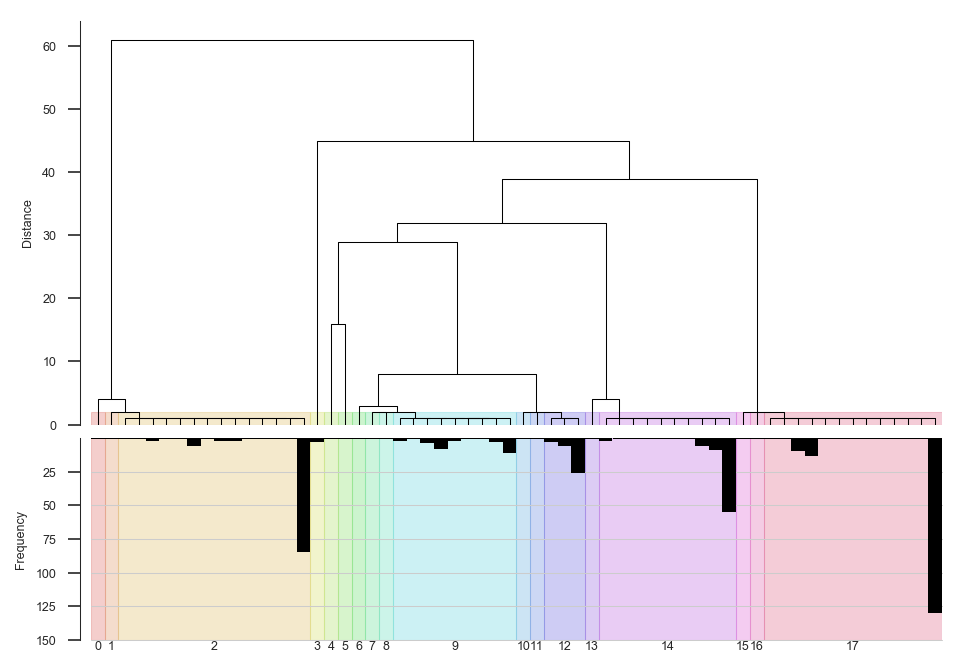

In [3]:
# Default plot... 
# cuts the tree at height 2 (so max distance within each cluster is 1)...
# highlights all clusters...
# labels all clusters.
fig_haplotypes_clustered(h_vgsc_995S, dpi=150);

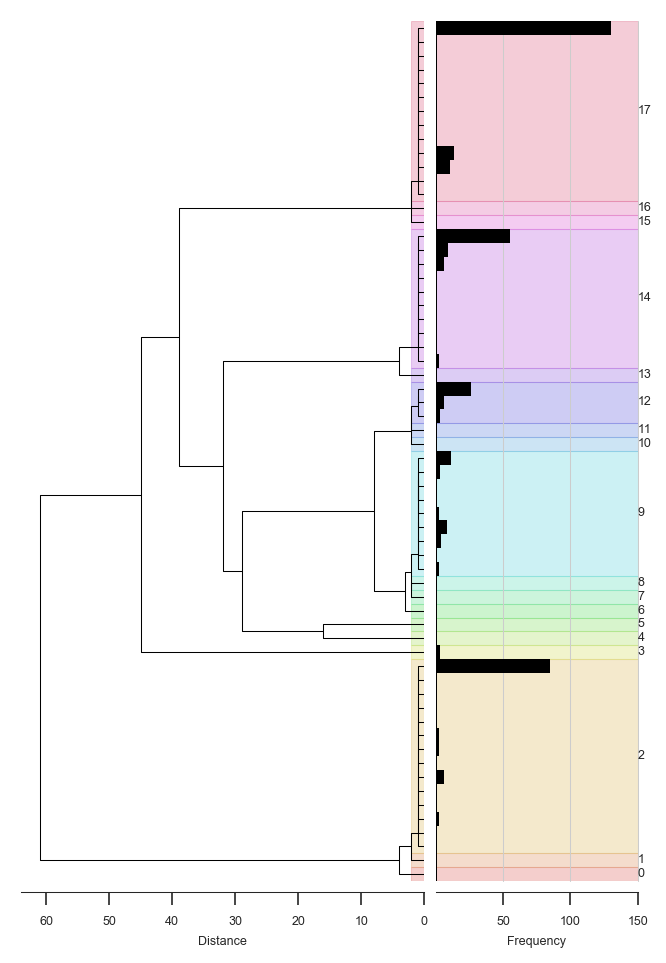

In [4]:
# Change the orientation...
fig_haplotypes_clustered(h_vgsc_995S, orientation='left', dpi=150);

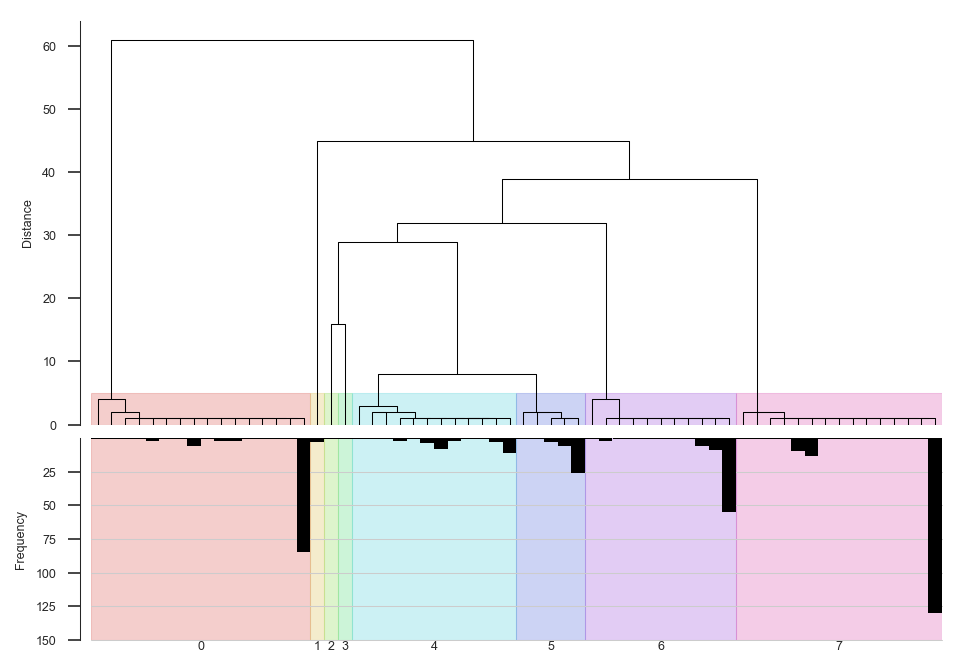

In [5]:
# Try a different cut height...
fig_haplotypes_clustered(h_vgsc_995S, cut_height=5, dpi=150);

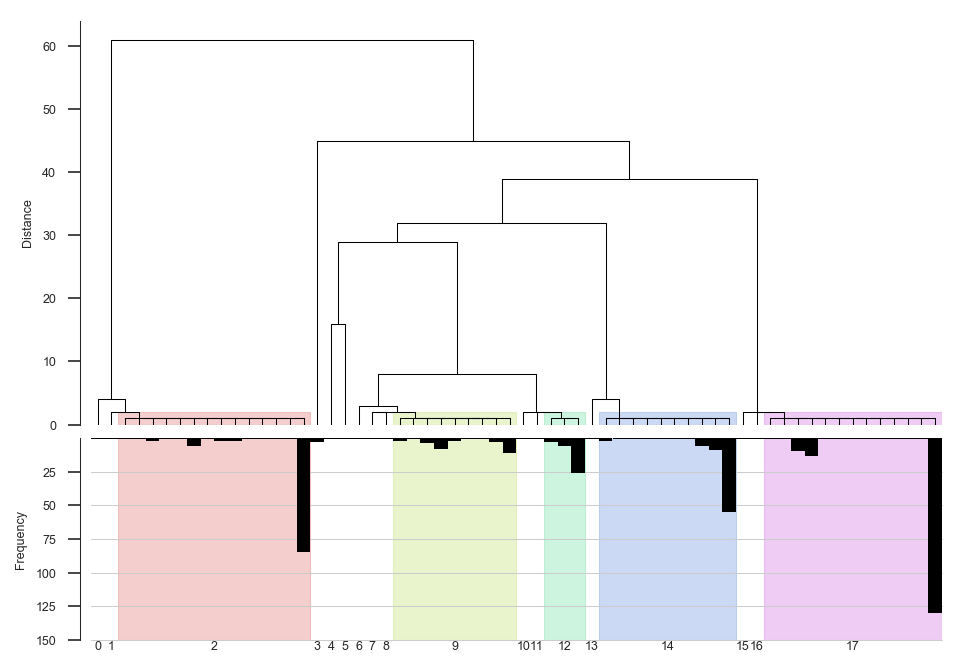

In [6]:
# Choose to highlight only clusters above a certain size...
fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5);

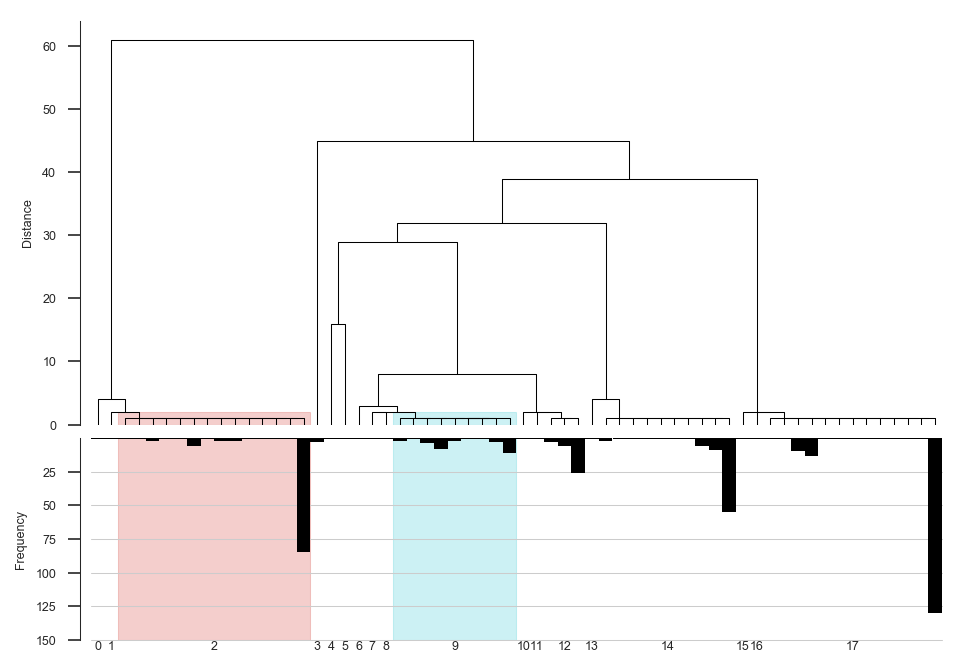

In [7]:
# Manually choose which clusters to highlight...
fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=[2, 9]);

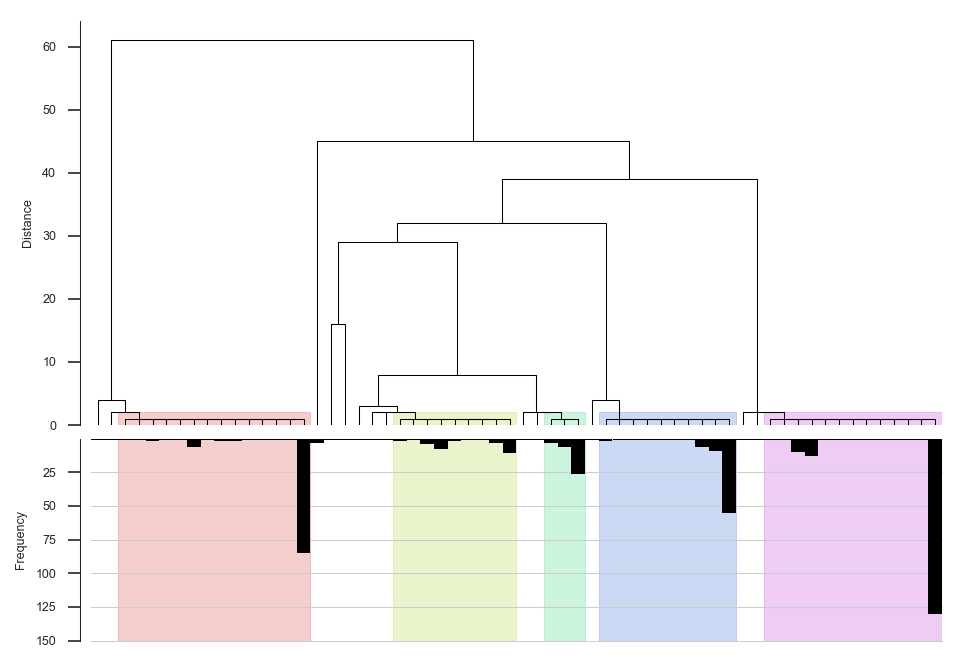

In [8]:
# Turn off cluster labels...
fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5, label_clusters=False);

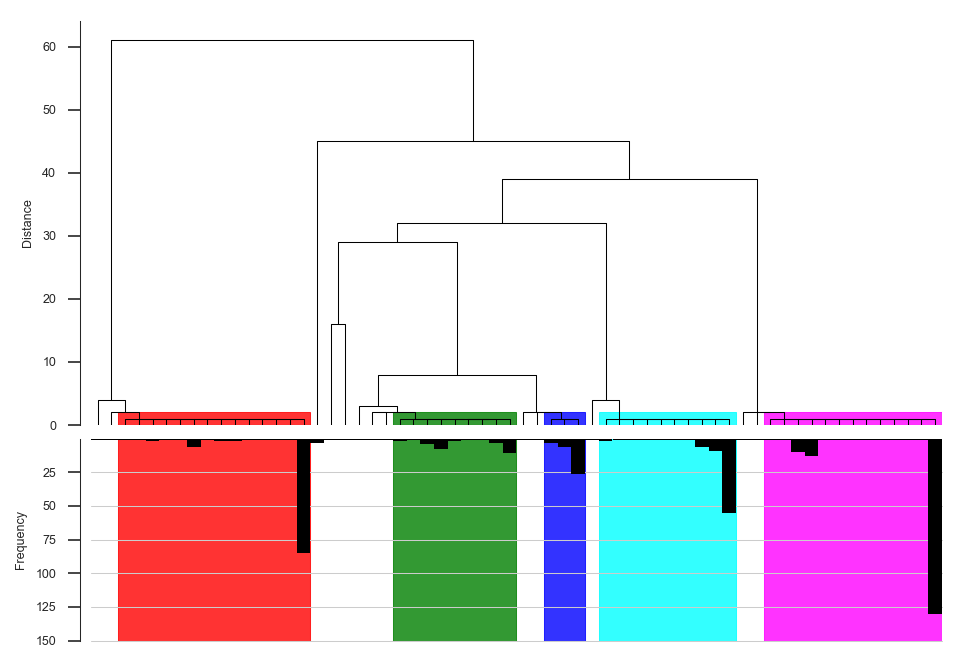

In [9]:
# Use your favourite colors...
fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5, label_clusters=False, 
                         highlight_colors=['red', 'green', 'blue', 'cyan', 'magenta', 'yellow'],
                         highlight_alpha=.8);

### Return values

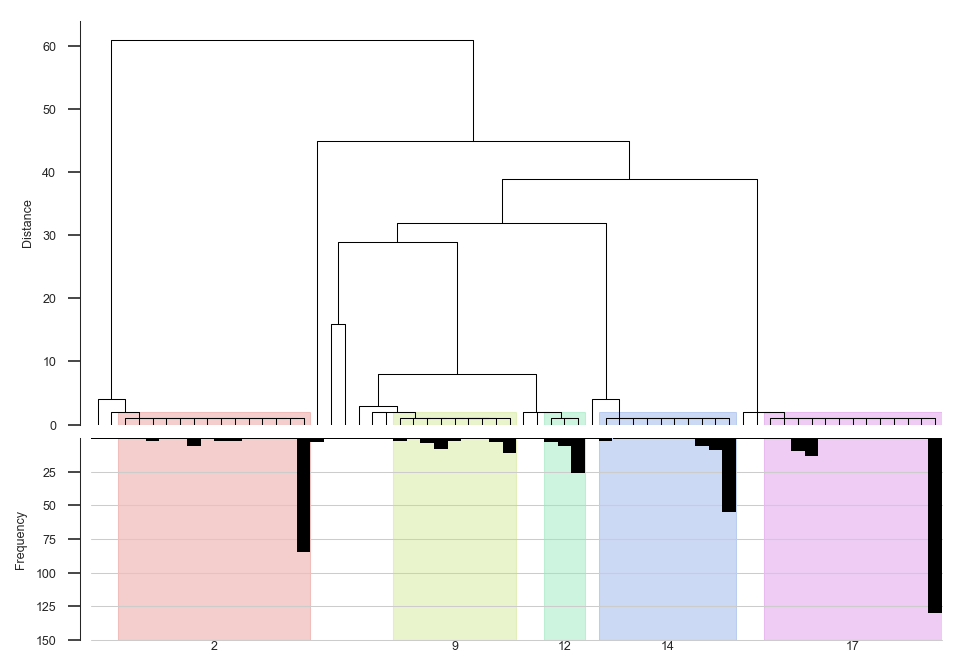

In [10]:
# What does this function return?
fig, ax_dend, ax_freq, cluster_spans, leaf_obs = fig_haplotypes_clustered(h_vgsc_995S, dpi=150, highlight_clusters=5, label_clusters=5)

#### Customising axes

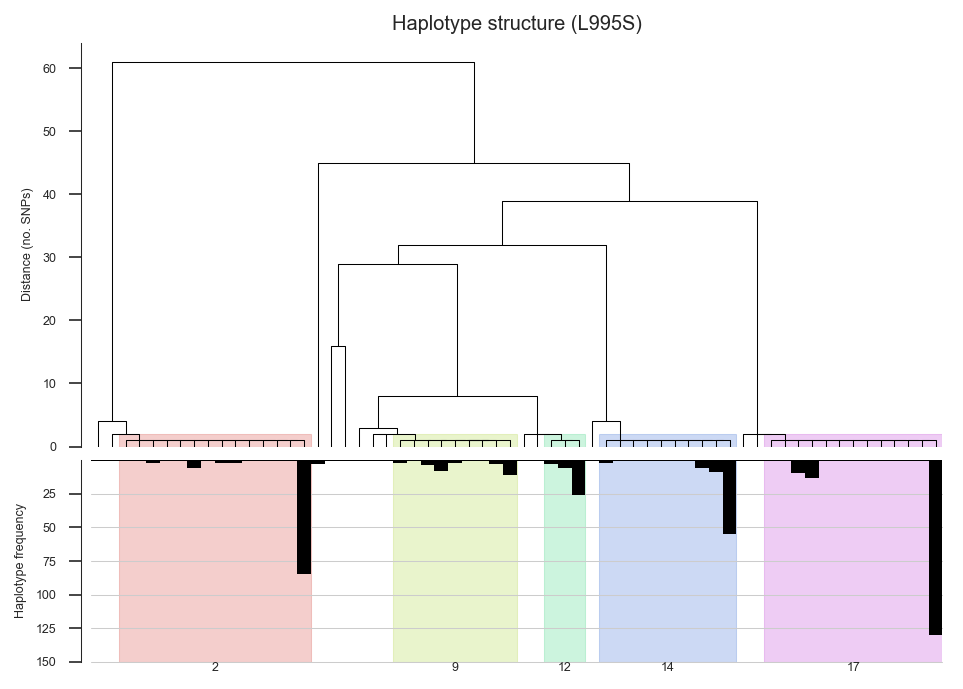

In [11]:
# E.g., use returned axes objects to customise labels etc. ...
cut_height = 2
fig, ax_dend, ax_freq, cluster_spans, leaf_obs = fig_haplotypes_clustered(h_vgsc_995S, cut_height=cut_height, dpi=150, 
                                                                          highlight_clusters=5, label_clusters=5)
ax_dend.set_title('Haplotype structure (L995S)')
ax_dend.set_ylabel('Distance (no. SNPs)')
ax_freq.set_ylabel('Haplotype frequency');

#### Accessing information about clusters

In [12]:
# cluster_spans is useful for accessing information about each cluster...
cluster_spans

[(0, 1, array([85])),
 (1, 2, array([17])),
 (2,
  16,
  array([  0,   1,   3,   4,   5,   7,  11,  15,  16,  19,  21,  23,  25,
          28,  29,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  45,
          47,  50,  51,  55,  57,  59,  61,  63,  64,  65,  71,  73,  75,
          77,  79,  82,  83,  86,  87,  88,  89,  91,  94,  95, 100, 101,
         103, 107, 109, 111, 114, 115, 119, 121, 122, 123, 126, 127, 128,
         129, 131, 133, 135, 137, 139, 140, 141, 144, 145, 147, 148, 149,
         151, 157, 158, 159, 163, 164, 165, 167, 169, 171, 172, 173, 176,
         177, 181, 183, 184, 185, 186, 187, 188, 189, 193, 195, 197, 199,
         201, 203])),
 (16, 17, array([277, 316, 346])),
 (17, 18, array([294])),
 (18, 19, array([369])),
 (19, 20, array([327])),
 (20, 21, array([278])),
 (21, 22, array([357])),
 (22,
  31,
  array([276, 282, 283, 284, 286, 287, 289, 291, 293, 299, 303, 304, 306,
         307, 311, 318, 320, 321, 322, 325, 326, 328, 330, 332, 336, 337,
         34

In [13]:
# E.g., cluster labelled "17" in the plot:
cluster_idx = 17
dend_start, dend_stop, cluster_hap_indices = cluster_spans[cluster_idx]

In [14]:
# These are positions in the dendrogram where the cluster starts and stops:
dend_start, dend_stop

(49, 62)

In [15]:
# These are the indices of the haplotypes in the cluster
cluster_hap_indices

array([  2,   6,   8,   9,  10,  12,  13,  14,  18,  20,  22,  24,  26,
        27,  30,  31,  32,  34,  44,  46,  48,  49,  52,  53,  54,  56,
        58,  60,  62,  66,  67,  68,  69,  70,  72,  74,  76,  78,  80,
        81,  84,  90,  92,  93,  96,  97,  98,  99, 102, 104, 105, 106,
       108, 110, 112, 116, 117, 118, 120, 124, 125, 130, 132, 134, 136,
       138, 142, 143, 146, 150, 152, 153, 154, 155, 156, 160, 161, 162,
       166, 168, 170, 174, 175, 178, 179, 180, 182, 190, 191, 192, 194,
       196, 198, 200, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
       266, 267, 268, 269, 270, 271, 272])

In [16]:
# How many haplotypes in the cluster?
len(cluster_hap_indices)

163

In [17]:
# N.B., these are relative to the haplotype array passed into the function.
# To extract only haplotypes in this cluster...
cluster_haps = h_vgsc_995S.take(cluster_hap_indices, axis=1)
cluster_haps

<HaplotypeArray shape=(1718, 163) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

#### Outputting haplotype data in other formats

In [18]:
cluster_hap_ids = hap_ids_995S.take(cluster_hap_indices)

In [19]:
sequences = cluster_haps.astype('S1').T

In [20]:
allel.io.write_fasta('../data/demo.hapclust.995S.cut{}.cluster{}.fasta'.format(cut_height, 
                                                                          cluster_idx),
                     sequences=list(sequences), 
                     names=cluster_hap_ids, 
                     mode='w', 
                     width=80)

In [22]:
# TODO other formats if needed

#### Mapping dendrogram leaves onto haplotypes

In [23]:
# leaf_obs can also be useful, it maps the leaves of the dendrogram onto indices of original observations...
# need this if ever you want to plot the haplotypes themselves

# E.g., the first leaf of the dendrogram contains these haplotypes:
leaf_obs[0]

[85]

In [24]:
# E.g., the 8th leaf of the dendrogram contains these haplotypes:
leaf_obs[7]

[126, 40, 38, 50, 86, 188]

In [25]:
# To extract a haplotype array matching the leaves of the dendrogram...

# only need one index per leaf, as all haplotypes per leaf are identical
indices = [l[0] for l in leaf_obs]

# take unique haplotypes in order shown in dendrogram
h_vgsc_995S_dend = h_vgsc_995S.take(indices, axis=1)
h_vgsc_995S_dend

<HaplotypeArray shape=(1718, 62) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

## Haplotype networks (minimum spanning tree)

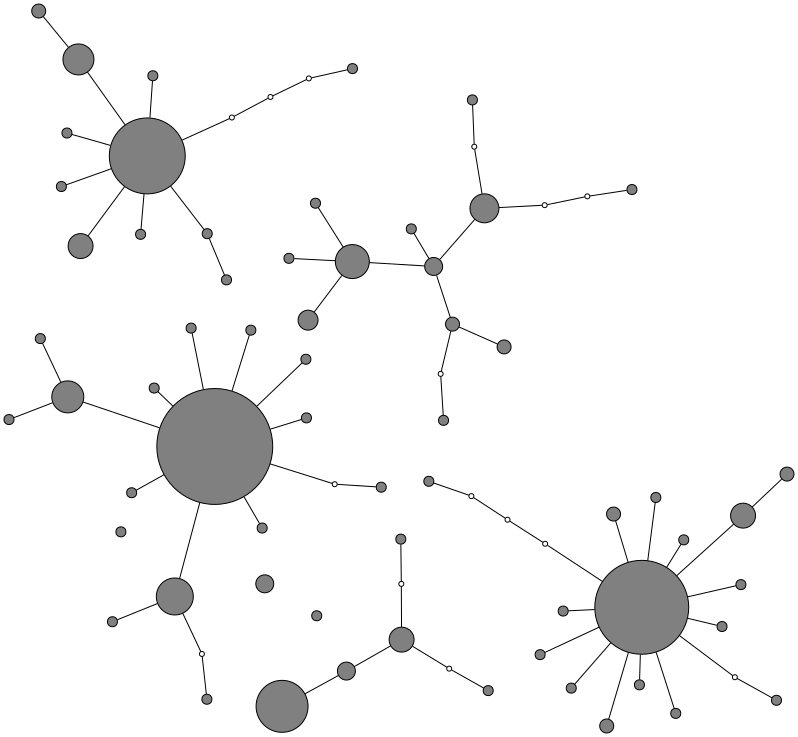

In [26]:
# make a network of all L995S haplotypes
graph = graph_haplotype_network(h_vgsc_995S)
graph

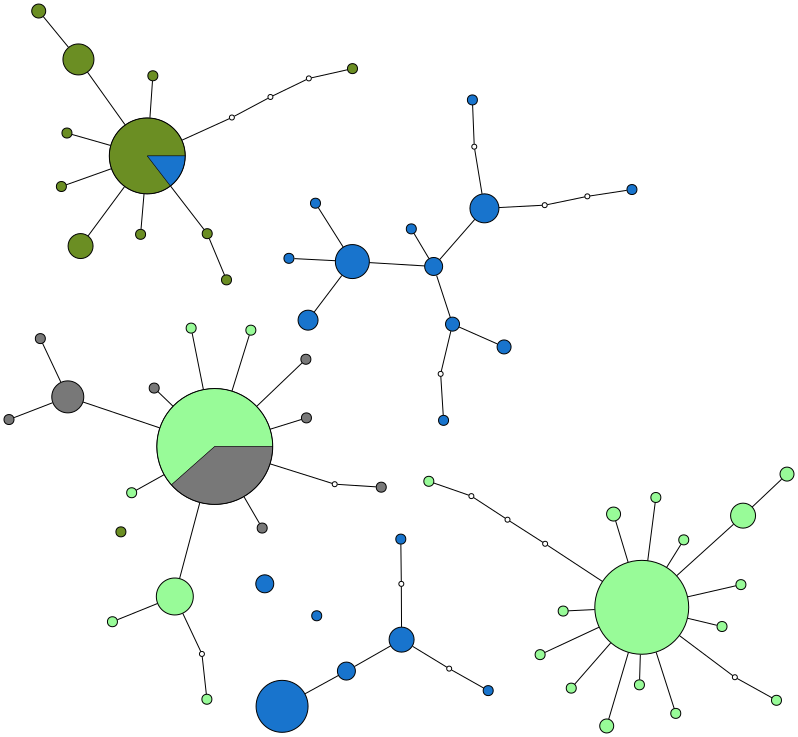

In [27]:
# add some color
graph = graph_haplotype_network(h_vgsc_995S, hap_colors=hap_colors_995S)
graph

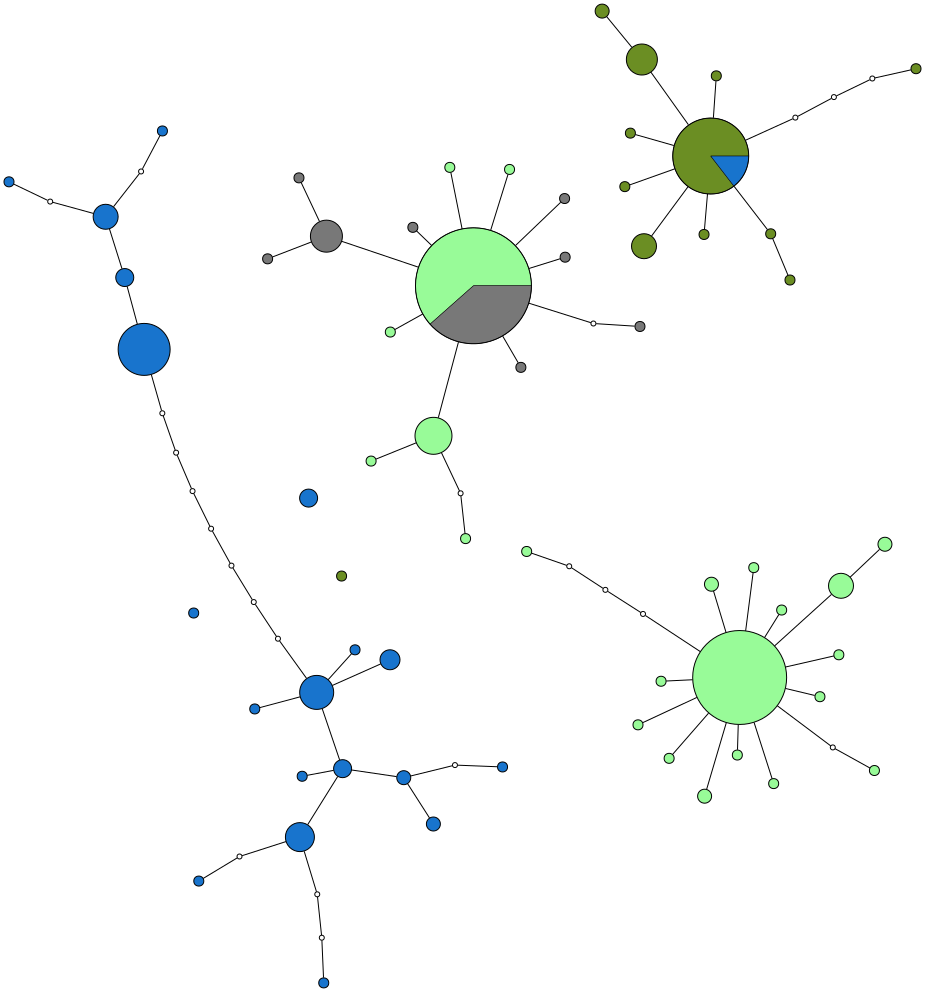

In [28]:
# change the maximum connection distance
graph = graph_haplotype_network(h_vgsc_995S, 
                                hap_colors=hap_colors_995S,
                                max_dist=10)
graph

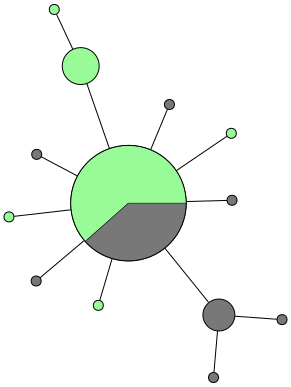

In [29]:
# plot a network for just a single cluster that we extracted earlier from the dendrogram
cluster_hap_pops = hap_pops_995S[cluster_hap_indices]
cluster_hap_colors = np.array([pop_colors[p] for p in cluster_hap_pops])
graph = graph_haplotype_network(cluster_haps, hap_colors=cluster_hap_colors)
graph